#Set-up:


In [1]:
pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 3.8 MB/s eta 0:00:00


In [2]:
#Imports:

import logging


import numpy as np

import pandas as pd

import seaborn as sns

import diffprivlib.models as dp
import pickle

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import sys

In [3]:
# Print library versions
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"pickle version: {pickle.format_version}")
print(f"matplotlib version: {plt.matplotlib.__version__}")
print(f"torch version: {torch.__version__}")
print(f"Python version: {sys.version}")

numpy version: 1.23.5
pandas version: 1.5.3
seaborn version: 0.13.1
pickle version: 4.0
matplotlib version: 3.7.1
torch version: 2.1.0+cu121
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [4]:
# modify the directory for the "Book 1 " dataset containing the first 20 lines of the dataset in the line below
df_p2 = pd.read_csv("/content/Book1.csv")
# modify the directory for the "Full heart assignment2 " dataset containing the entire dataset
df = pd.read_csv("/content/heart_assignment2-W2024 (3).csv").sample(frac = 1)

#Part 2 :K-anonimity and l-diversity

The following code generates a k-anonimity version of the subset of the given dataset.
It is worth mentionning that the obtained table was then checked manually and then illustrated via excel. The final version of the table is available in the pdf submitted alongside this document.

In [5]:
#Inspecting that the dataframe for part 2 is correct

df_p2.head()

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Unnamed: 13
0,45.0,F,Hispanic,ATA,130.0,237.0,0.0,Normal,170.0,N,0.0,Up,0.0,NaN
1,54.0,M,Black,ATA,110.0,208.0,0.0,Normal,142.0,N,0.0,Up,0.0,NaN
2,37.0,M,Hispanic,ASY,140.0,207.0,0.0,Normal,130.0,Y,1.5,Flat,1.0,NaN
3,48.0,F,Black,ATA,120.0,284.0,0.0,Normal,120.0,N,0.0,Up,0.0,NaN
4,37.0,F,Black,NAP,130.0,211.0,0.0,Normal,142.0,N,0.0,Up,0.0,NaN


In [6]:
#Changing the data types from Categorical data (Y/N for example) into numerical data (1,0 for example)

categorical = set((
 'Sex',
 'Race',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope'))

In [7]:
#Changing the type of the features containing "object" data into "categorical data"

for name in categorical:
    df_p2[name] = df_p2[name].astype('category')
#df.dtypes

In [8]:
#Generating a list of all the columns in our dataset


data = df_p2.values.tolist()
#print(data)
columns = []
for column in df_p2.columns:
  columns.append(column)
print(columns)
#df.dtypes

['Age', 'Sex', 'Race', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease', 'Unnamed: 13']


In [9]:
# Implementation of the corrected anonypy library for Part 2 of the assignment.
#Anonypy will be used later in this section to generate a k-anonymous dataset.

def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:

            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)


def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions


def agg_categorical_column(series):
    return ','.join(set(series))

def agg_numerical_column(series):
    return series.mean()

def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    # Keep track of non-feature columns
    non_feature_columns = [col for col in df.columns if col not in feature_columns]

    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            logging.info("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break

        # Extract feature columns
        grouped_columns = df.loc[partition, feature_columns]

        # Extract non-feature columns
        non_feature_values = df.loc[partition, non_feature_columns].iloc[0].to_dict()

        # Merge feature and non-feature columns
        values = {**grouped_columns.to_dict(), **non_feature_values}

        # Update sensitive value and count
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column: 'count'})
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column: sensitive_value,
                'count': count,
            })
            rows.append(values.copy())

    return pd.DataFrame(rows)


In [10]:
#Calculating the fullspan of our dataset using the previously created get_spans method.

full_spans = get_spans(df_p2, df_p2.index)
#full_spans

In [11]:
feature_columns = ['Age', 'Sex', 'Race'] #i.e. the quasi-identifying features
sensitive_column = 'HeartDisease' #i.e. the sensitive column in our data set (the presence or not of a heart disease)
finished_partitions = partition_dataset(df_p2, feature_columns, sensitive_column, full_spans, is_k_anonymous)
#len(finished_partitions)

In [12]:
#Building our k-anonymized dataset

dfn = build_anonymized_dataset(df_p2, finished_partitions, feature_columns, sensitive_column)

In [13]:
dfn

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Unnamed: 13,count
0,"{4: 37.0, 8: 42.0, 11: 43.0, 14: 43.0}","{4: 'F', 8: 'F', 11: 'F', 14: 'F'}","{4: 'Black', 8: 'Other', 11: 'Other', 14: 'His...",NAP,130.0,211.0,0.0,Normal,142.0,N,0.0,Up,0.0,NaN,4
1,"{0: 45.0, 1: 54.0, 3: 48.0, 12: 60.0, 16: 49.0}","{0: 'F', 1: 'M', 3: 'F', 12: 'M', 16: 'F'}","{0: 'Hispanic ', 1: 'Black', 3: 'Black', 12: '...",ATA,130.0,237.0,0.0,Normal,170.0,N,0.0,Up,0.0,NaN,4
2,"{0: 45.0, 1: 54.0, 3: 48.0, 12: 60.0, 16: 49.0}","{0: 'F', 1: 'M', 3: 'F', 12: 'M', 16: 'F'}","{0: 'Hispanic ', 1: 'Black', 3: 'Black', 12: '...",ATA,130.0,237.0,0.0,Normal,170.0,N,0.0,Up,1.0,NaN,1
3,"{5: 58.0, 7: 49.0, 9: 54.0, 15: 44.0, 17: 44.0}","{5: 'M', 7: 'M', 9: 'F', 15: 'M', 17: 'M'}","{5: 'White', 7: 'White', 9: 'Other', 15: 'Whit...",ATA,136.0,164.0,0.0,ST,99.0,Y,2.0,Flat,0.0,NaN,2
4,"{5: 58.0, 7: 49.0, 9: 54.0, 15: 44.0, 17: 44.0}","{5: 'M', 7: 'M', 9: 'F', 15: 'M', 17: 'M'}","{5: 'White', 7: 'White', 9: 'Other', 15: 'Whit...",ATA,136.0,164.0,0.0,ST,99.0,Y,2.0,Flat,1.0,NaN,3
5,"{2: 37.0, 13: 36.0, 19: 36.0}","{2: 'M', 13: 'M', 19: 'M'}","{2: 'Hispanic ', 13: 'Hispanic ', 19: 'Hispani...",ASY,140.0,207.0,0.0,Normal,130.0,Y,1.5,Flat,0.0,NaN,1
6,"{2: 37.0, 13: 36.0, 19: 36.0}","{2: 'M', 13: 'M', 19: 'M'}","{2: 'Hispanic ', 13: 'Hispanic ', 19: 'Hispani...",ASY,140.0,207.0,0.0,Normal,130.0,Y,1.5,Flat,1.0,NaN,2
7,"{6: 39.0, 10: 38.0, 18: 40.0}","{6: 'M', 10: 'M', 18: 'M'}","{6: 'Black', 10: 'Black', 18: 'Black'}",ATA,120.0,204.0,0.0,Normal,145.0,N,0.0,Up,0.0,NaN,2
8,"{6: 39.0, 10: 38.0, 18: 40.0}","{6: 'M', 10: 'M', 18: 'M'}","{6: 'Black', 10: 'Black', 18: 'Black'}",ATA,120.0,204.0,0.0,Normal,145.0,N,0.0,Up,1.0,NaN,1


In [14]:
#reducing any duplicates generated in the previous cell.

df2 = dfn.apply(lambda x: x.astype(str)).drop_duplicates(subset=["Age","Sex","Race"], keep='first')
df2

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Unnamed: 13,count
0,"{4: 37.0, 8: 42.0, 11: 43.0, 14: 43.0}","{4: 'F', 8: 'F', 11: 'F', 14: 'F'}","{4: 'Black', 8: 'Other', 11: 'Other', 14: 'His...",NAP,130.0,211.0,0.0,Normal,142.0,N,0.0,Up,0.0,nan,4
1,"{0: 45.0, 1: 54.0, 3: 48.0, 12: 60.0, 16: 49.0}","{0: 'F', 1: 'M', 3: 'F', 12: 'M', 16: 'F'}","{0: 'Hispanic ', 1: 'Black', 3: 'Black', 12: '...",ATA,130.0,237.0,0.0,Normal,170.0,N,0.0,Up,0.0,nan,4
3,"{5: 58.0, 7: 49.0, 9: 54.0, 15: 44.0, 17: 44.0}","{5: 'M', 7: 'M', 9: 'F', 15: 'M', 17: 'M'}","{5: 'White', 7: 'White', 9: 'Other', 15: 'Whit...",ATA,136.0,164.0,0.0,ST,99.0,Y,2.0,Flat,0.0,nan,2
5,"{2: 37.0, 13: 36.0, 19: 36.0}","{2: 'M', 13: 'M', 19: 'M'}","{2: 'Hispanic ', 13: 'Hispanic ', 19: 'Hispani...",ASY,140.0,207.0,0.0,Normal,130.0,Y,1.5,Flat,0.0,nan,1
7,"{6: 39.0, 10: 38.0, 18: 40.0}","{6: 'M', 10: 'M', 18: 'M'}","{6: 'Black', 10: 'Black', 18: 'Black'}",ATA,120.0,204.0,0.0,Normal,145.0,N,0.0,Up,0.0,nan,2


In [15]:
#Making sure that our dataset is indeed 5-anonymous

is_k_anonymous(dfn,finished_partitions, sensitive_column,3)

True

#Part 3 :  Differential Privacy

##Preprocessing (code taken from assignment 1)

In [16]:
#Making sure that the head of our dataframe is correct (making also sure that it is not the same dataframe as the one used for Part 2 of the assignment)

df.head()

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
453,60,M,Other,ASY,120,0,0,Normal,133,Y,2.0,Up,0
317,56,M,White,ASY,140,0,1,Normal,121,Y,1.8,Up,1
27,52,M,Black,ATA,120,284,0,Normal,118,N,0.0,Up,0
467,63,F,White,ATA,132,0,0,Normal,130,N,0.1,Up,0
479,56,M,Hispanic,NAP,170,0,0,LVH,123,Y,2.5,Flat,1


In [17]:
#Checking the types of the dataframe
df.dtypes

Age                 int64
Sex                object
Race               object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [18]:
#The mapping dictionnary we have created between categorical data and numerical data
# can be found here.

#Note: a discrepency of 2 can be found between the indices of the samples on the csv and the ones on the pd data frame.
#For example, sample 25 in the csv is sample 23 in the pd.Dataframe
#This is due to the fact that the first line of data in the csv is 2 (the first line of the csv being line [1]
# and being the title line, whereas the pd.Dataframe starts at line [0]).

Columns_to_change  = ['Sex', 'Race', 'ChestPainType', 'RestingECG',
       'ExerciseAngina', 'ST_Slope']
mapping_dict = {}
for c in Columns_to_change:
  df[c] = df[c].astype('category')
  mapping_dict[c] = dict(enumerate(df[c].cat.categories))
columns = df.select_dtypes(['category']).columns
df[columns] = df[columns].apply(lambda x: x.cat.codes)

# copy the data
df_min_max_scaled = df.copy()

# apply normalization techniques. This ensures that features with
# different scales contribute equally to model training, preventing dominance by features with larger magnitudes.

for column in df_min_max_scaled.columns:
	df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())


df = df_min_max_scaled
df

,Age,Sex,Race,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
453,0.653061,1.0,0.75,0.000000,0.600,0.000000,0.0,0.5,0.514085,1.0,0.522727,1.0,0.0
317,0.571429,1.0,1.00,0.000000,0.700,0.000000,1.0,0.5,0.429577,1.0,0.500000,1.0,1.0
27,0.489796,1.0,0.25,0.333333,0.600,0.470978,0.0,0.5,0.408451,0.0,0.295455,1.0,0.0
467,0.714286,0.0,1.00,0.333333,0.660,0.000000,0.0,0.5,0.492958,0.0,0.306818,1.0,0.0
479,0.571429,1.0,0.50,0.666667,0.850,0.000000,0.0,0.0,0.443662,1.0,0.579545,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,0.714286,1.0,0.75,0.000000,0.650,0.421227,0.0,0.0,0.612676,0.0,0.454545,0.5,1.0
501,0.714286,1.0,0.00,0.000000,0.650,0.510779,0.0,0.5,0.549296,1.0,0.522727,0.5,1.0
111,0.591837,1.0,1.00,0.000000,0.750,0.422886,0.0,0.5,0.225352,1.0,0.636364,0.5,1.0
381,0.448980,1.0,1.00,0.000000,0.575,0.000000,0.0,0.5,0.422535,1.0,0.352273,0.5,1.0


In [19]:
#Spliting the dataset into training and testing.
#It is also important to note that in our case, we are not actually building a prediction from our model
# Therefore, as we are not iterating over some "test" cases, we could also have split our dataset into only 3 sets : training, testing and validation.


X = df.drop('HeartDisease', axis = 1).to_numpy()
y = df['HeartDisease'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

##**Question 4:**

Text(0.5, 1.0, 'Accuracy Score: 0.8195956454121306')

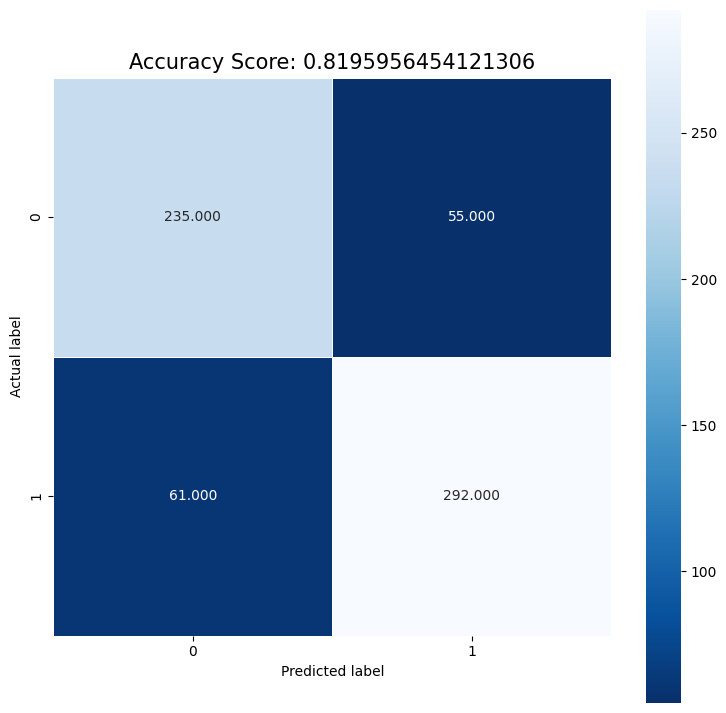

In [20]:
#Importing the sklearn Logistic Regression model
model = LogisticRegression()

#Fitting the model
model.fit(x_train, y_train)
predictions = model.predict(x_test) #Predicting heart diseases on the test data set
score = model.score(x_test, y_test) #scoring the performance of the model on the test data set
cm = metrics.confusion_matrix(y_test, predictions) #Creating the confusion matrix

#Plotting the confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

In [21]:
#Results using 10 fold cross validation

KFold = 10

scores = cross_val_score((model), X, y, cv=KFold)

for s in range (KFold):
  print(f'The score of the {s} fold is of {scores[s]} ')
print("All in all, we achieved an accuracy of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The score of the 0 fold is of 0.8586956521739131 
The score of the 1 fold is of 0.8586956521739131 
The score of the 2 fold is of 0.8152173913043478 
The score of the 3 fold is of 0.8369565217391305 
The score of the 4 fold is of 0.8260869565217391 
The score of the 5 fold is of 0.9239130434782609 
The score of the 6 fold is of 0.8586956521739131 
The score of the 7 fold is of 0.8478260869565217 
The score of the 8 fold is of 0.8351648351648352 
The score of the 9 fold is of 0.8241758241758241 
All in all, we achieved an accuracy of 0.85 with a standard deviation of 0.03


##**Question 5**:

/usr/local/lib/python3.10/dist-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


Text(0.5, 1.0, 'Accuracy Score: 0.7325038880248833')

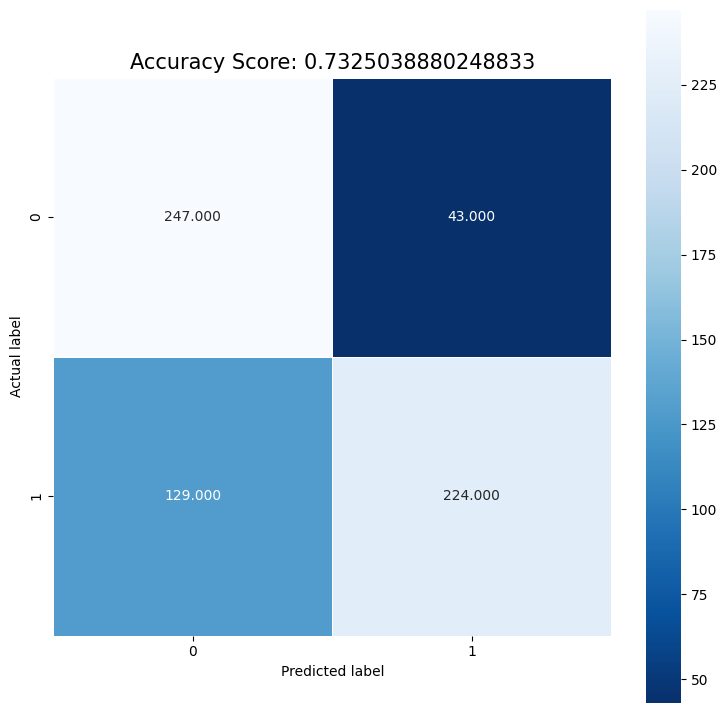

In [22]:
#Importing the differentially private Logistic Regression model
model_dp = dp.LogisticRegression(epsilon = 0.5)

#Fitting the model
model_dp.fit(x_train, y_train)
predictions = model_dp.predict(x_test) #Predicting heart diseases on the test data set
score = model_dp.score(x_test, y_test) #scoring the performance of the model on the test data set
cm = metrics.confusion_matrix(y_test, predictions) #Creating the confusion matrix

#Plotting the confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

In [23]:
#Results using 10 fold cross validation

KFold = 10

scores = cross_val_score((model_dp), X, y, cv=KFold)

for s in range (KFold):
  print(f'The score of the {s} fold is of {scores[s]} ')
print("All in all, we achieved an accuracy of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The score of the 0 fold is of 0.6739130434782609 
The score of the 1 fold is of 0.782608695652174 
The score of the 2 fold is of 0.6304347826086957 
The score of the 3 fold is of 0.75 
The score of the 4 fold is of 0.6630434782608695 
The score of the 5 fold is of 0.7065217391304348 
The score of the 6 fold is of 0.391304347826087 
The score of the 7 fold is of 0.7065217391304348 
The score of the 8 fold is of 0.7032967032967034 
The score of the 9 fold is of 0.6153846153846154 
All in all, we achieved an accuracy of 0.66 with a standard deviation of 0.10


##Question 7:

In [24]:
clf = LogisticRegression(solver="lbfgs") #Creating a non-private logistic regression model to be used as our baseline
clf.fit(x_train, y_train) #fitting our model to the dataset.

baseline = clf.score(x_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 81.96%


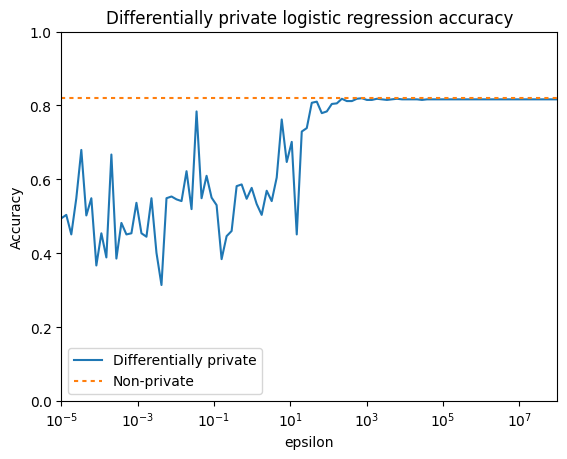

In [25]:
accuracy = []
epsilons = np.logspace(-5, 8, 100)


#Here, we will be creating a different private logistic regression classifier for each value of epsilon in our interval
#Then, for each of those models, we will fit that model to our dataset, and calculate the achieved accuracy.

for eps in epsilons:
    dp_clf = dp.LogisticRegression(epsilon=eps,data_norm=10)
    dp_clf.fit(x_train, y_train)
    accuracy.append(dp_clf.score(x_test, y_test))

pickle.dump((epsilons, baseline, accuracy), open("lr_accuracy.p", "wb" ) )


epsilons, baseline, accuracy = pickle.load(open("lr_accuracy.p", "rb"))



#We will then plot the achieved results of each model (as a function of epsilon), and we will also show the previously calculated baseline (non-private classifier)
plt.semilogx(epsilons, accuracy, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()


Plot of the evolution of the classification accuracy with respect to epsilon

##**Question8 :**

/usr/local/lib/python3.10/dist-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


Text(0.5, 1.0, 'Accuracy Score: 0.7511664074650077')

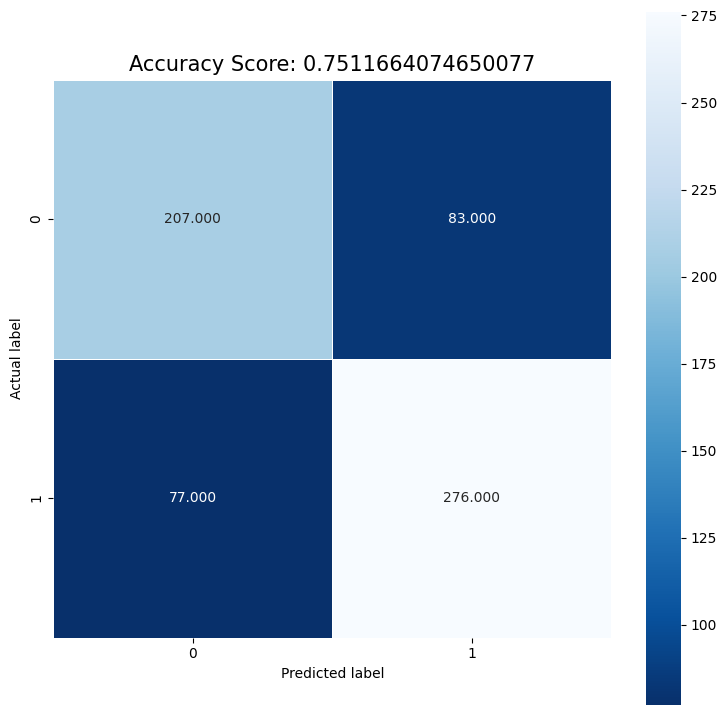

In [26]:
#Importing the differential logistic regression model with epsilon = 5 (optimal epsilon)
model_dp = dp.LogisticRegression(epsilon = 5)

#Fitting the model
model_dp.fit(x_train, y_train)
predictions = model_dp.predict(x_test) #Predicting heart diseases on the test data set
score = model_dp.score(x_test, y_test) #scoring the performance of the model on the test data set
cm = metrics.confusion_matrix(y_test, predictions) #Creating the confusion matrix

#Plotting the confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

In [27]:
#Results using 10 fold cross validation

KFold = 10

scores = cross_val_score((model_dp), X, y, cv=KFold)

for s in range (KFold):
  print(f'The score of the {s} fold is of {scores[s]} ')
print("All in all, we achieved an accuracy of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The score of the 0 fold is of 0.8043478260869565 
The score of the 1 fold is of 0.8043478260869565 
The score of the 2 fold is of 0.8152173913043478 
The score of the 3 fold is of 0.8043478260869565 
The score of the 4 fold is of 0.8043478260869565 
The score of the 5 fold is of 0.9347826086956522 
The score of the 6 fold is of 0.8478260869565217 
The score of the 7 fold is of 0.8369565217391305 
The score of the 8 fold is of 0.7362637362637363 
The score of the 9 fold is of 0.8021978021978022 
All in all, we achieved an accuracy of 0.82 with a standard deviation of 0.05
